In [1]:
import pandas as pd
import numpy as np
from matplotlib.ticker import LogFormatter
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt
import json
import plategig

PROJECT_PATH = Path('/project/greencenter/Toprak_lab/shared/plategig/projects')
PROJECT_ID = '241015_Fatma'

### Step 1: Read Plate Information

#### UFPF Input

In [2]:
# Parse all experiments under this project
exps = dict()

for path in (PROJECT_PATH / PROJECT_ID / 'data' / 'raw').glob('[!~]*.ufpf.xlsx'):
    exp_name = path.stem.rstrip('.ufpf')
    exps[exp_name] = plategig.ufpf(path, timepoint_in_sheetnames=True)

In [3]:
exps

{'20241015_MIC_CTXM15_CEFT': <plategig.plategig.ufpf at 0x2aad38af9bb0>,
 '20241015_MIC_CTXM15_CEFE': <plategig.plategig.ufpf at 0x2aad3663c530>,
 '20241015_MIC_CTXM15_AZT': <plategig.plategig.ufpf at 0x2aad392ae5d0>,
 '20241015_MIC_CTXM15_AMP': <plategig.plategig.ufpf at 0x2aad398e3440>}

In [4]:
# select_exp = '20241015_MIC_CTXM15'
select_exp = "20241015_MIC_CTXM15_CEFT"
display(exps[select_exp].OD)
display(exps[select_exp].plate_info)

,Row,Column,OD,Plate_ID,Well
0,1,1,0.045,0,A1
1,2,1,0.051,0,B1
2,3,1,0.051,0,C1
3,4,1,0.049,0,D1
4,5,1,0.049,0,E1
...,...,...,...,...,...
91,4,12,0.043,11,D12
92,5,12,0.045,11,E12
93,6,12,0.045,11,F12
94,7,12,0.045,11,G12


,Row,Column,Antibiotic,Plate_ID,Well,Dose,Strain
0,1,1,MEDIA ONLY,0,A1,NaN,nan
1,2,1,CEFTAZIDIME,0,B1,0.025,DEAD_H0
2,3,1,CEFTAZIDIME,0,C1,0.025,DEAD_H0
3,4,1,CEFTAZIDIME,0,D1,0.025,DEAD_H0
4,5,1,CEFTAZIDIME,0,E1,0.025,SVL_MIX_H0
...,...,...,...,...,...,...,...
91,4,12,MEDIA ONLY,11,D12,NaN,nan
92,5,12,MEDIA ONLY,11,E12,NaN,nan
93,6,12,MEDIA ONLY,11,F12,NaN,nan
94,7,12,MEDIA ONLY,11,G12,NaN,nan


### Data processing

In [5]:
df = exps[select_exp].OD
df_plate_info = exps[select_exp].plate_info

In [6]:
df_plate_info.Plate_ID.unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

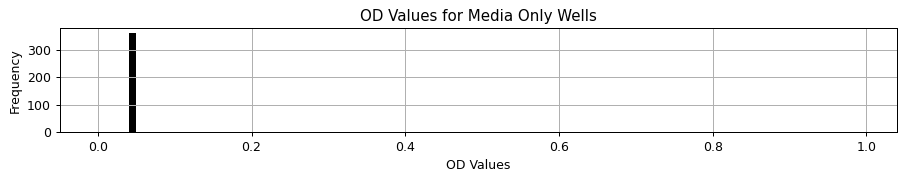

In [7]:
median_background_all_plates = plategig.static.calc_median_background_all_plates(
    df, df_plate_info, plot=True)

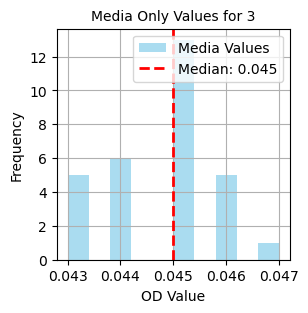

np.float64(0.045)

In [8]:
plategig.static.plot_single_plate_media_only_wells(df, df_plate_info, plate_id=3, column_name='OD')

In [9]:
df_plate_info

,Row,Column,Antibiotic,Plate_ID,Well,Dose,Strain
0,1,1,MEDIA ONLY,0,A1,NaN,nan
1,2,1,CEFTAZIDIME,0,B1,0.025,DEAD_H0
2,3,1,CEFTAZIDIME,0,C1,0.025,DEAD_H0
3,4,1,CEFTAZIDIME,0,D1,0.025,DEAD_H0
4,5,1,CEFTAZIDIME,0,E1,0.025,SVL_MIX_H0
...,...,...,...,...,...,...,...
91,4,12,MEDIA ONLY,11,D12,NaN,nan
92,5,12,MEDIA ONLY,11,E12,NaN,nan
93,6,12,MEDIA ONLY,11,F12,NaN,nan
94,7,12,MEDIA ONLY,11,G12,NaN,nan


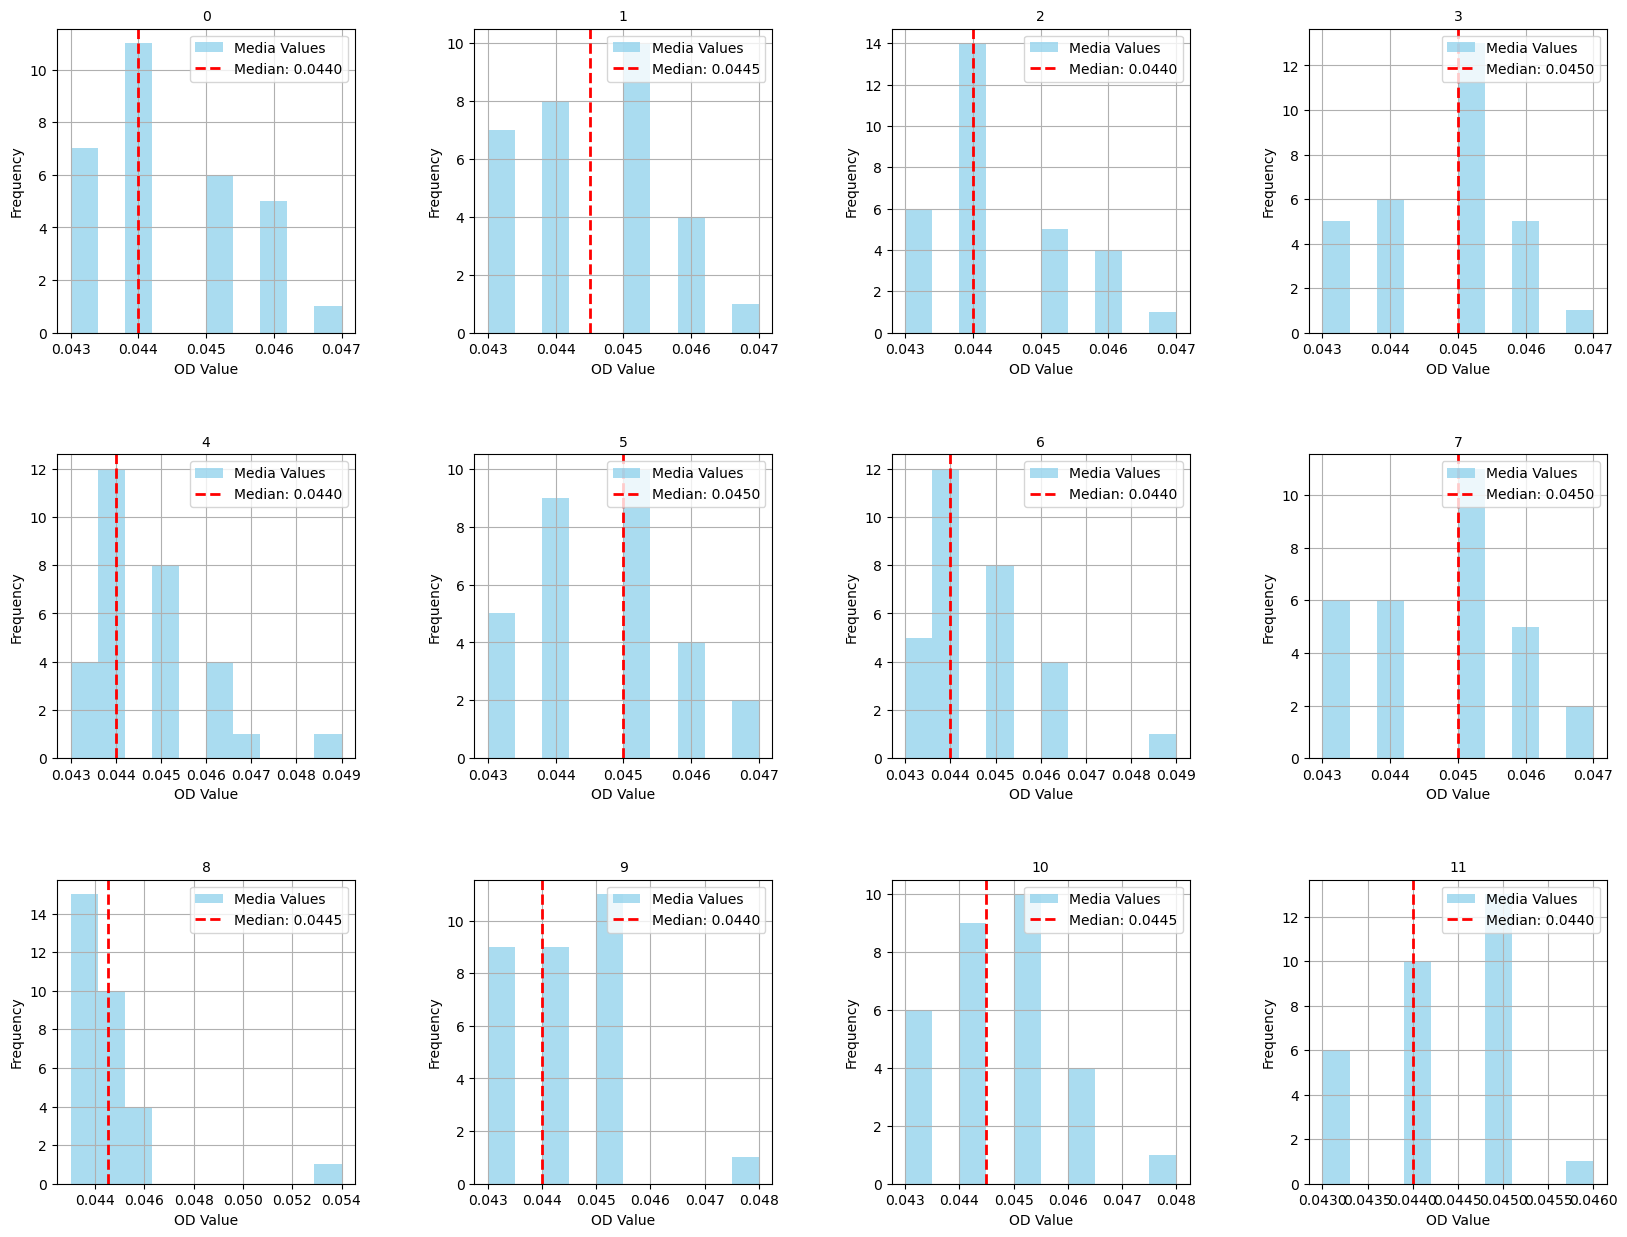

In [10]:
plategig.static.plot_all_plates_media_only_wells(df, df_plate_info, 'OD')

Apply background correction for all plates

In [20]:
results = [plategig.static.apply_background_correction(
            df, df_plate_info, plate_id, median_background_all_plates)
           for plate_id in df_plate_info.Plate_ID.unique()]
df_bc = pd.concat(results)
df_bc

,Row,Column,OD,Plate_ID,Well,OD_final
0,1,1,0.045,0,A1,0.001
1,2,1,0.051,0,B1,0.007
2,3,1,0.051,0,C1,0.007
3,4,1,0.049,0,D1,0.005
4,5,1,0.049,0,E1,0.005
...,...,...,...,...,...,...
91,4,12,0.043,11,D12,0.000001
92,5,12,0.045,11,E12,0.001
93,6,12,0.045,11,F12,0.001
94,7,12,0.045,11,G12,0.001


#### Evaluate growth metrics

In [21]:
df_plate_info

,Row,Column,Antibiotic,Plate_ID,Well,Dose,Strain
0,1,1,MEDIA ONLY,0,A1,NaN,nan
1,2,1,CEFTAZIDIME,0,B1,0.025,DEAD_H0
2,3,1,CEFTAZIDIME,0,C1,0.025,DEAD_H0
3,4,1,CEFTAZIDIME,0,D1,0.025,DEAD_H0
4,5,1,CEFTAZIDIME,0,E1,0.025,SVL_MIX_H0
...,...,...,...,...,...,...,...
91,4,12,MEDIA ONLY,11,D12,NaN,nan
92,5,12,MEDIA ONLY,11,E12,NaN,nan
93,6,12,MEDIA ONLY,11,F12,NaN,nan
94,7,12,MEDIA ONLY,11,G12,NaN,nan


In [22]:
# Prep the analysis dataframe
df_analysis = pd.merge(df_plate_info, df_bc, on=['Plate_ID', 'Well', 'Row', 'Column'])
# Replace nan values in dose column with 0
df_analysis['Dose'] = df_analysis['Dose'].fillna(0)
# Replace nan values in dose column with 0
df_analysis['Strain'] = df_analysis['Strain'].fillna('Media Only')
# Drop rows with nan values in columns Antibiotic, Strain, Dose
# df_analysis = df_analysis.dropna(subset=['Antibiotic', 'Strain', 'Dose'])
# Explicit replicate IDs per Antibiotic, Strain, Dose
df_analysis['Replicate'] = df_analysis.groupby(['Strain', 'Antibiotic', 'Dose']).cumcount() + 1
df_analysis

,Row,Column,Antibiotic,Plate_ID,Well,Dose,Strain,OD,OD_final,Replicate
0,1,1,MEDIA ONLY,0,A1,0.000,nan,0.045,0.001,1
1,2,1,CEFTAZIDIME,0,B1,0.025,DEAD_H0,0.051,0.007,1
2,3,1,CEFTAZIDIME,0,C1,0.025,DEAD_H0,0.051,0.007,2
3,4,1,CEFTAZIDIME,0,D1,0.025,DEAD_H0,0.049,0.005,3
4,5,1,CEFTAZIDIME,0,E1,0.025,SVL_MIX_H0,0.049,0.005,1
...,...,...,...,...,...,...,...,...,...,...
1147,4,12,MEDIA ONLY,11,D12,0.000,nan,0.043,0.000001,356
1148,5,12,MEDIA ONLY,11,E12,0.000,nan,0.045,0.001,357
1149,6,12,MEDIA ONLY,11,F12,0.000,nan,0.045,0.001,358
1150,7,12,MEDIA ONLY,11,G12,0.000,nan,0.045,0.001,359


In [23]:
strains = list(set(df_analysis['Strain'].str.lower()) - set(['media only', 'cells only', np.nan]))
strains

['dead_h12.45',
 'wt_h9',
 'nan',
 'svl_mix_h0',
 'dead_h9',
 'cml_mix_h9',
 'cml_mix_h24',
 'svl_mix_h12.45',
 'cml_mix_h3',
 'dead_h24',
 'cml_mix_h12.45',
 'wt_h3',
 'cml_mix_h0',
 'cml_mix_h6',
 'wt_h24',
 'dead_h0',
 'svl_mix_h6',
 'svl_mix_h9',
 'dead_h6',
 'wt_h6',
 'svl_mix_h3',
 'dead_h3',
 'svl_mix_h24',
 'wt_h0',
 'wt_h12.45']

In [24]:
antibiotics = list(set(df_analysis['Antibiotic'].str.lower()) - set(['media only', 'cells only', np.nan]))
antibiotics

['ceftazidime']

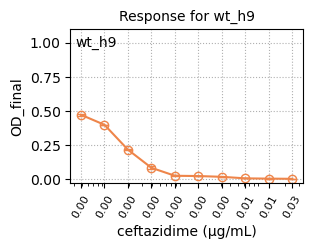

In [25]:
# Colors for predefined strains
strain_colors = {strain:color for strain, color in zip(strains, sns.color_palette('muted')[:len(strains)])}
# strain_colors = {
#     'BW25113': 'black', 'WT': 'blue', 'CML': 'purple', 'DEAD': 'red'    
# }

# Adjust the figure size as needed
fig, ax = plt.subplots(figsize=(3, 2))
plategig.static.plot_dose_response_curve_errorbar(df_analysis, strains[1], antibiotics[0], strain_colors, ax=ax)

In [26]:
valid_combinations = plategig.static.prep_valid_combinations(
    df_analysis,
    multiplex=['Strain', 'Antibiotic'],
    ic50_threshold=0.5,
    mic_threshold=0.05)

In [27]:
growth_features = plategig.static.apply_phenotyper(df_analysis, valid_combinations)
growth_features = plategig.static.cap_growth_features_within_experiment_range(growth_features)
growth_features.head()

,Strain,Antibiotic,Status,IC50,MIC,IC50_ci_lower,IC50_ci_upper,MIC_ci_lower,MIC_ci_upper,max_growth,hill_coeff,ic50_threshold,mic_threshold,x_fit,y_fit,ic50_bootstrap,insufficient_drug
0,DEAD_H0,CEFTAZIDIME,PASS,0.058326,0.058326,0.058326,0.058326,0.058326,0.058326,0.0045,4.484689,0.00225,0.000225,"[2.441406250000001e-05, 2.6368645969050462e-05...","[0.004500000000000004, 0.004500000000000004, 0...","[2.6386641898249956, 2.629255869746755, 2.6184...",True
1,SVL_MIX_H0,CEFTAZIDIME,PASS,0.058326,0.058326,0.058326,0.058326,0.058326,0.058326,0.0055,0.191914,0.00275,0.000275,"[2.441406250000001e-05, 2.6368645969050462e-05...","[0.005261117180009301, 0.005257716831931758, 0...","[20.602660831761014, 12813.98887499436, 735079...",True
2,CML_MIX_H0,CEFTAZIDIME,PASS,0.058326,0.058326,0.058326,0.058326,0.058326,0.058326,0.0030,4.310867,0.00150,0.000150,"[2.441406250000001e-05, 2.6368645969050462e-05...","[0.0030000000000000027, 0.0030000000000000027,...","[2.170819446771704, 2.159552771088651, 2.28406...",True
3,WT_H0,CEFTAZIDIME,PASS,0.058326,0.058326,0.058326,0.058326,0.058326,0.058326,0.0045,0.521995,0.00225,0.000225,"[2.441406250000001e-05, 2.6368645969050462e-05...","[0.0044801309758004115, 0.004479319669574795, ...","[0.2547420087439147, 5.848172426564414, 0.5010...",True
4,DEAD_H3,CEFTAZIDIME,PASS,0.058326,0.058326,0.058326,0.058326,0.058326,0.058326,0.0110,0.356424,0.00550,0.000550,"[2.441406250000001e-05, 2.6368645969050462e-05...","[0.010567487039825466, 0.010555935815107597, 0...","[0.1293133328509433, 0.057723243128937986, 0.1...",True


In [28]:
growth_features.tail()

,Strain,Antibiotic,Status,IC50,MIC,IC50_ci_lower,IC50_ci_upper,MIC_ci_lower,MIC_ci_upper,max_growth,hill_coeff,ic50_threshold,mic_threshold,x_fit,y_fit,ic50_bootstrap,insufficient_drug
19,WT_H12.45,CEFTAZIDIME,PASS,0.000227,0.000594,0.000220,0.000233,0.000554,0.000646,0.6205,3.053927,0.31025,0.031025,"[2.441406250000001e-05, 2.6368645969050462e-05...","[0.619813249048797, 0.6196314018458312, 0.6194...","[0.00022960033304608268, 0.0002304734155130881...",False
20,DEAD_H24,CEFTAZIDIME,PASS,0.000137,0.000764,0.000112,0.000160,0.000611,0.001020,0.6035,1.713634,0.30175,0.030175,"[2.441406250000001e-05, 2.6368645969050462e-05...","[0.5736814761427663, 0.5697101303751739, 0.565...","[0.00014964095798258257, 0.0001378691470294668...",False
21,SVL_MIX_H24,CEFTAZIDIME,PASS,0.002413,0.006062,0.001689,0.003948,0.002692,0.013177,0.6900,3.196336,0.34500,0.034500,"[2.441406250000001e-05, 2.6368645969050462e-05...","[0.6899997099312343, 0.6899996289680992, 0.689...","[0.0035296919698247294, 0.0018796969797057496,...",False
22,CML_MIX_H24,CEFTAZIDIME,PASS,0.004000,0.005452,0.003888,0.004175,0.005436,0.005495,0.7505,9.505448,0.37525,0.037525,"[2.441406250000001e-05, 2.6368645969050462e-05...","[0.7505, 0.7505, 0.7505, 0.7505, 0.7505, 0.750...","[0.00404500303935437, 0.004051548615718818, 0....",False
23,WT_H24,CEFTAZIDIME,PASS,0.000517,0.003851,0.000493,0.000550,0.003517,0.004298,0.7620,1.466737,0.38100,0.038100,"[2.441406250000001e-05, 2.6368645969050462e-05...","[0.753448783325526, 0.7524389730826223, 0.7513...","[0.0005163707110542823, 0.0004992823733792595,...",False


0.05832645197880584 0.00022500000000000024
0.05832645197880584 0.0002750000000000019
0.05832645197880584 0.00015000000000000015
0.05832645197880584 0.00022500000000000024
0.05832645197880584 0.0005500000000000001
0.09882041655304241 0.004075000000000001
0.024794799078523118 0.004975000000000002
0.03381678064383311 0.0015999999999999996
0.0002382794181076446 0.010825000000000003
0.00022826415461113362 0.014975000000000013
0.0012030346151971373 0.016500000000000004
0.0003414842170817612 0.014025000000000008
0.0001286207312888541 0.01970000000000094
0.0003885368986616148 0.023975000000000354
0.00807004968891409 0.025525
0.0006316001153227232 0.024000000000000323
0.0001238921174033056 0.02890000000000143
0.006509739675820498 0.0319
0.03435955638337907 0.031775
0.0005944593878789704 0.031025000000000004
0.0007642855437709037 0.030175000000000004
0.0060617986070021735 0.0345
0.005451794403898744 0.037525000000000606
0.0038509374783306702 0.038100000000000016


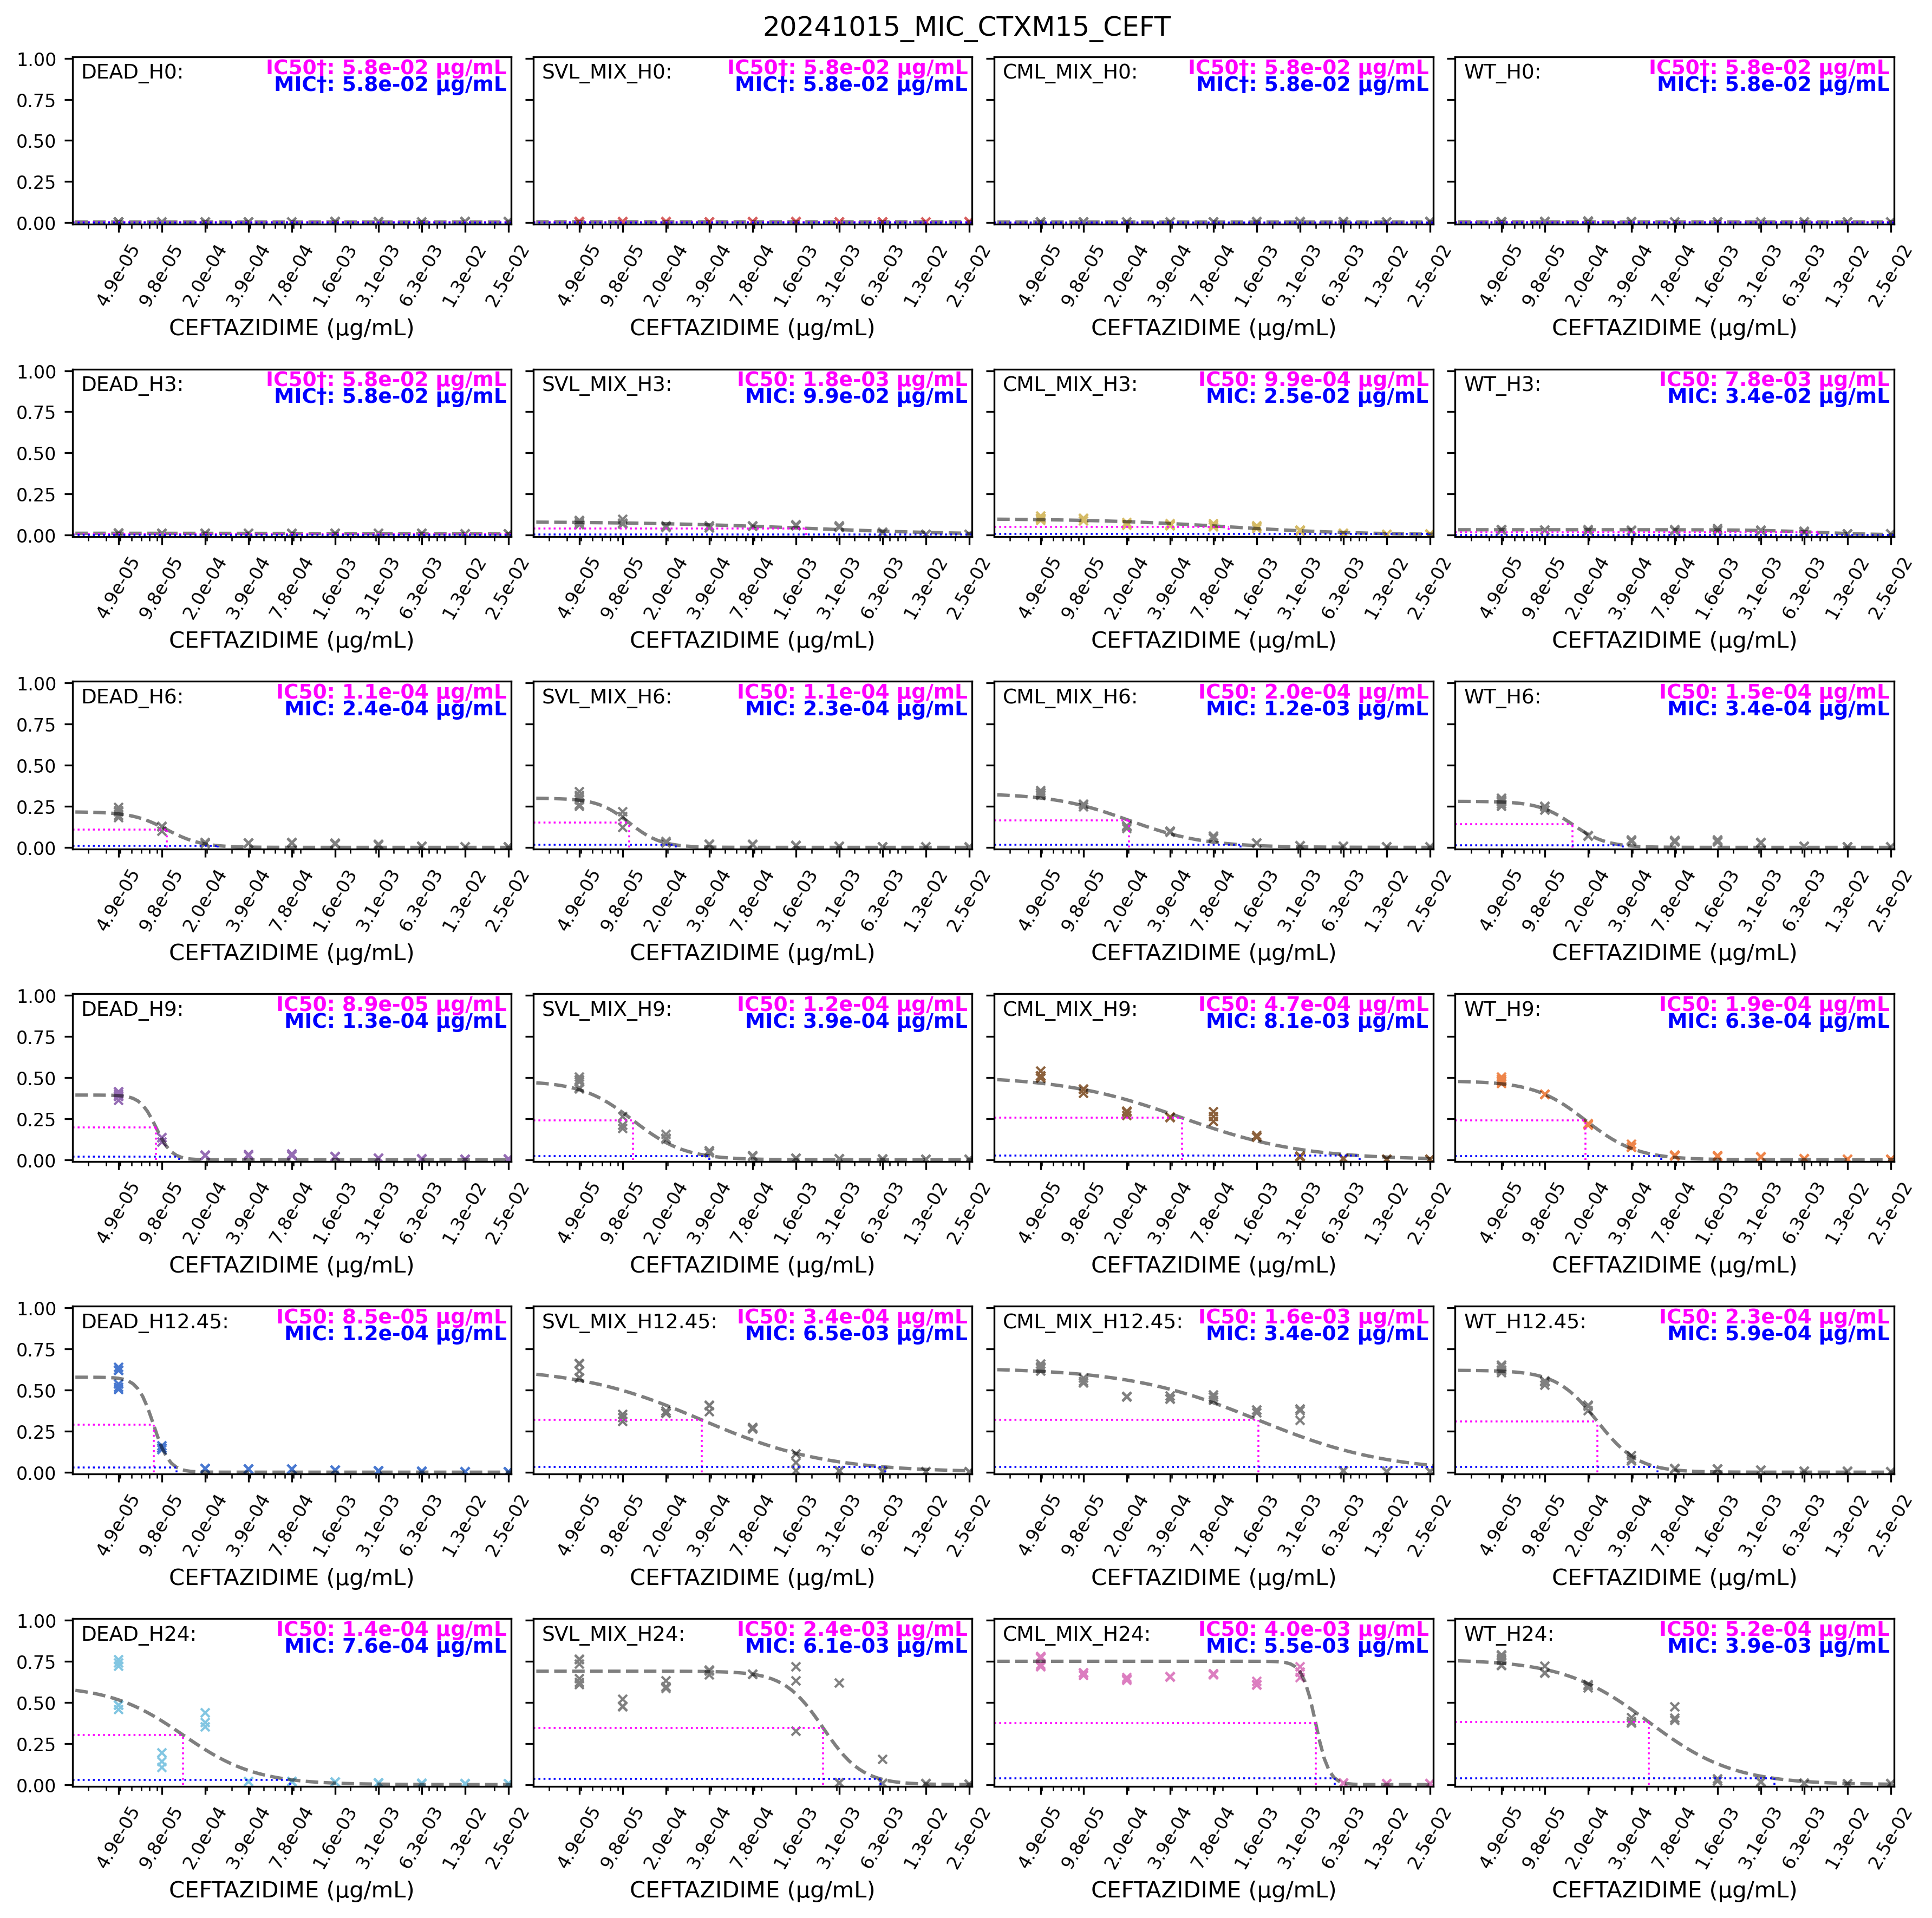

In [29]:
num_drugs = growth_features['Antibiotic'].nunique()
num_experiments = growth_features.shape[0]
num_cols = 4
num_rows = num_experiments//num_cols + (num_experiments % num_cols > 0)
# num_cols = num_experiments//num_drugs
# fig, axes = plt.subplots(num_experiments//num_replicates, num_replicates,
#                        figsize=(num_replicates*3, num_experiments*2), dpi=90)
fig, axes = plt.subplots(num_rows, num_cols,
                       figsize=(num_cols*3, num_rows*2), dpi=300)

for ix, row in growth_features.iterrows():
    plategig.static.plot_dose_response_curve_fit(df_analysis,
                                                growth_features=growth_features,
                                                strain_colors=strain_colors,
                                                strain=row['Strain'],
                                                antibiotic=row['Antibiotic'],
                                                ax=axes.flat[ix])
    
    if row['Status'] == 'FAIL':
        axes.flat[ix].text(0.5, 0.5, f'FAIL', color='red', fontsize=12, fontweight='bold',
                        ha='center', va='center', transform=axes.flat[ix].transAxes)
        # gray out the entire axes
        axes.flat[ix].set_facecolor('lightgray')
    if ix % num_cols != 0:
        axes.flat[ix].set_yticklabels([])
# Hide the rest of the axes
for ix in range(num_experiments, num_cols*num_rows):
    axes.flat[ix].axis('off')

fig.suptitle(f'{select_exp}')
fig.tight_layout()
# set empty space between subplots
fig.subplots_adjust(wspace=0.05)
# fig.savefig(PROJECT_PATH / 'data' / PROJECT_ID / 'figures' / f'{select_exp} IC50 fits.png', dpi=300, bbox_inches='tight')

In [ ]:
(
growth_features[['Antibiotic','Strain','Status','IC50','MIC','IC50_ci_lower','IC50_ci_upper', 'max_growth', 'hill_coeff']]
.to_csv(PROJECT_PATH / 'data' / PROJECT_ID / 'figures' / f'{select_exp} IC50 estimations.csv',
          index=False)
)

: 

### IC50 Combined Plot

In [ ]:
# Export growth_features
cols_to_export = ['Strain','Antibiotic','Status','IC50','IC50_ci_lower','IC50_ci_upper', 'MIC', 'MIC_ci_lower', 'MIC_ci_upper', 'insufficient_drug']
growth_features[cols_to_export].to_csv(
    PROJECT_PATH / 'data' / PROJECT_ID / 'figures' / f'{select_exp} IC50 estimations.csv', index=False)

final_chart = alt.hconcat()
for drug in sorted(growth_features['Antibiotic'].unique()):
    filtered_growth_features = growth_features[cols_to_export]
    filtered_growth_features = filtered_growth_features.query(f'Antibiotic == "{drug}" & Status == "PASS"')
    filtered_growth_features['StrainGroup'] = filtered_growth_features['Strain'].str.extract(r'^(.*)_[^_]*$')
    filtered_growth_features['Timepoint'] = filtered_growth_features['Strain'].str.extract(r'[hH]([-+]?\d*\.\d+|[-+]?\d+\.?\d*)$').astype(float)
    filtered_growth_features.sort_values(by=['StrainGroup', 'Timepoint'], inplace=True)
    strain_order = filtered_growth_features['Strain'].unique().tolist()

    base = alt.Chart(filtered_growth_features).encode(
        x=alt.X('Strain', sort=strain_order),
    ).properties(width=450, height=300)

    ic50 = base.mark_point(filled=True, size=200).encode(
        y=alt.Y('IC50:Q', scale=alt.Scale(type="log")),
        color='StrainGroup'
    )

    error_bars = base.mark_errorbar(ticks=True, size=10, thickness=2).encode(
        alt.Y("IC50_ci_lower:Q", scale=alt.Scale(type="log")).title('IC50'),
        alt.Y2("IC50_ci_upper:Q"),
        color='StrainGroup'
    )

    # Create a dagger symbol on the bars with insufficient_drug flag is true
    dagger = base.mark_text(align='center', baseline='middle', fontSize=14, color='black', fontWeight='bold', dy=-20, dx=0).encode(
        y=alt.Y('IC50'),
        text=alt.condition(
            alt.datum.insufficient_drug, if_true=alt.value("‡"), if_false=alt.value("")
            )
    )

    layered_chart = alt.layer(ic50, error_bars, dagger).properties(title=drug)

    final_chart |= layered_chart
final_chart = final_chart.resolve_scale(y='independent').configure_axis(
    labelFontSize=18,
    titleFontSize=18,
).configure_title(
    fontSize=18,
    anchor='middle',
).configure_legend(
    titleFontSize=18,
    labelFontSize=18,
)

# set final chart title to experiment name, make it centered
final_chart.title = select_exp
final_chart = final_chart.configure_title(anchor='middle')
final_chart.show()

alt.HConcatChart(...)

: 

### MIC combined plot

In [ ]:

final_chart = alt.hconcat()
for drug in sorted(growth_features['Antibiotic'].unique()):
    filtered_growth_features = growth_features[cols_to_export]
    filtered_growth_features = filtered_growth_features.query(f'Antibiotic == "{drug}" & Status == "PASS"')
    filtered_growth_features['StrainGroup'] = filtered_growth_features['Strain'].str.extract(r'^(.*)_[^_]*$')
    filtered_growth_features['Timepoint'] = filtered_growth_features['Strain'].str.extract(r'[hH]([-+]?\d*\.\d+|[-+]?\d+\.?\d*)$').astype(float)
    filtered_growth_features.sort_values(by=['StrainGroup', 'Timepoint'], inplace=True)
    strain_order = filtered_growth_features['Strain'].unique().tolist()

    base = alt.Chart(filtered_growth_features).encode(
        x=alt.X('Strain', sort=strain_order),
    ).properties(width=450, height=300)

    ic50 = base.mark_point(filled=True, size=200).encode(
        y=alt.Y('MIC:Q', scale=alt.Scale(type="log")),
        color='StrainGroup'
    )

    error_bars = base.mark_errorbar(ticks=True, size=10, thickness=2).encode(
        alt.Y("MIC_ci_lower:Q", scale=alt.Scale(type="log")).title('MIC'),
        alt.Y2("MIC_ci_upper:Q"),
        color='StrainGroup'
    )

    # Create a dagger symbol on the bars with insufficient_drug flag is true
    dagger = base.mark_text(align='center', baseline='middle', fontSize=14, color='black', fontWeight='bold', dy=-20, dx=0).encode(
        y=alt.Y('MIC:Q'),
        text=alt.condition(
            alt.datum.insufficient_drug, if_true=alt.value("‡"), if_false=alt.value("")
            )
    )

    layered_chart = alt.layer(ic50, error_bars, dagger).properties(title=drug)

    final_chart |= layered_chart
final_chart = final_chart.resolve_scale(y='independent').configure_axis(
    labelFontSize=18,
    titleFontSize=18,
).configure_title(
    fontSize=18,
    anchor='middle',
).configure_legend(
    titleFontSize=18,
    labelFontSize=18,
)

# set final chart title to experiment name, make it centered
final_chart.title = select_exp
final_chart = final_chart.configure_title(anchor='middle')
final_chart.show()

alt.HConcatChart(...)

: 

: 